## Task 2: train a PINN to invert for underlying parameters

#### Task

The second task is to use a PINN to **invert** for underlying parameters.

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

The key idea here is to also treat $\mu$ as a **learnable parameter** when training the PINN - so that we both simulate the solution and invert for this parameter.

In [12]:
#The important packages for this problem: 

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check if GPU is available:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # If it prints cuda, then you have a GPU available, otherwise it will print cpu. You can also run this code in Google Colab to use a GPU.

# If it prints cpu there is no problem, you can also run the code!

cuda


In [3]:
def Time_Independent_Schrodinger(L, n, x):
    """
    Defines the analytical solution to the time independent 1D Schrodinger equation problem.
    Returns the wavefunction of the particle in a box (torch tensor). 
    Parameters: L = Length of box (float)
                n = Energy state, ie n=1 is the ground state, n=2 is the first excited state,... (int)
                x = Position of the particle (torch tensor)
    """
    
    pi= torch.pi
    psi = torch.sqrt(2/L) * torch.sin( (n* pi * x) / L) 
    
    return psi

In [4]:
class FCN(nn.Module):
    """
    Defines a fully connected network.
    """
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, ACTIVATION):
        """
        Parameters: N_INPUT = Number of input features (int)
                    N_OUTPUT = Number of output features (int)
                    N_HIDDEN = Number of hidden units (int)
                    N_LAYERS = Number of hidden layers (int)
                    ACTIVATION = Activation function (string)

        """
        super().__init__()

        if ACTIVATION == 'tanh':
            activation = nn.Tanh
        elif ACTIVATION == 'relu':
            activation = nn.ReLU
        elif ACTIVATION == 'gelu':
            activation = nn.GELU
        else:
            raise ValueError("Activation function not recognized")
        
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        """
        Forward pass of the network.
        Parameters: x = input to the network (torch tensor)
        """
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [5]:
def plot_losses(losses1,losses2=None,losses3=None,losses4=None,lossestot=None):
    """
    Plots the loss function(s) over the iterations. The function can plot up to 5 losses,
     where they can all add up to the total loss(losses1+losses2+losses3+losses4 = lossestot).
     This losses could be the Mean Squared Error loss of the training data, the Differential Equation loss,
      the Boundary condition losses or whatever metric you would like. 
    Parameters: losses1 = List of losses (list)
                losses2 = List of losses (list) 
                losses3 = List of losses (list)
                losses4 = List of losses (list)
                lossestot = List of losses (list)
    """

    plt.figure()
    plt.title("Loss over epoch")
    plt.plot(losses1,label="ML Loss")
    if None not in (losses2, losses3, losses4,lossestot):
        plt.plot(losses2,label="Dif Eq loss")
        plt.plot(losses3,label="Boundary 1 loss")
        plt.plot(losses4,label="Boundary 2 loss")
        plt.plot(lossestot,label="Total loss")
    
    plt.legend()
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.yscale("log")   
    plt.show()

True value of Energy: 19.73921012878418


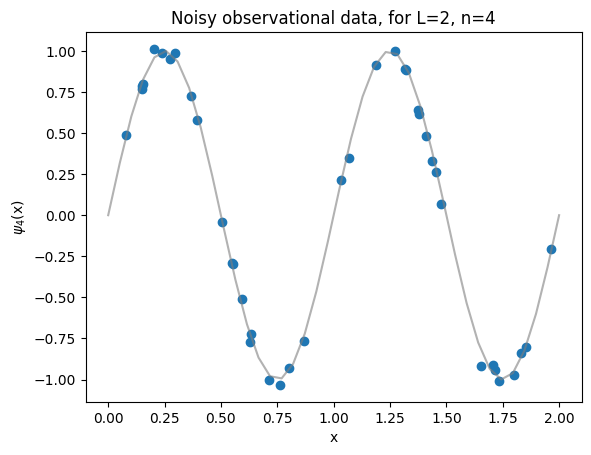

In [9]:
# first, create some noisy observational data
torch.manual_seed(123)

L = torch.tensor(2.0)
n = torch.tensor(4.0)

#set your constantes
hbar = 1 
m = 1

E = (n * torch.pi * hbar) **2 / (2*m*L**2)

print(f"True value of Energy: {E}")


x_obs = L*torch.rand(40).view(-1,1)
y_obs = Time_Independent_Schrodinger(L, n, x_obs) + 0.04*torch.randn_like(x_obs)

plt.figure()
plt.title("Noisy observational data, for L=2, n=4")
plt.scatter(x_obs[:,0], y_obs[:,0])
x_test = torch.linspace(0,L.item(),40).view(-1,1)
wave = Time_Independent_Schrodinger(L, n, x_test)
plt.plot(x_test[:,0], wave[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.xlabel("x")
plt.ylabel(r"$\psi_4$(x)")
plt.show()

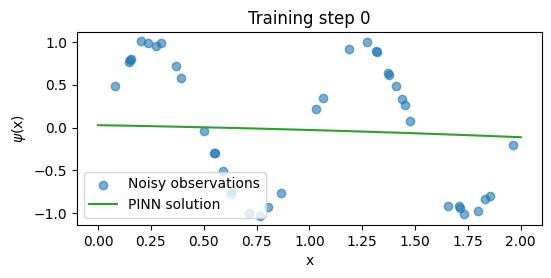

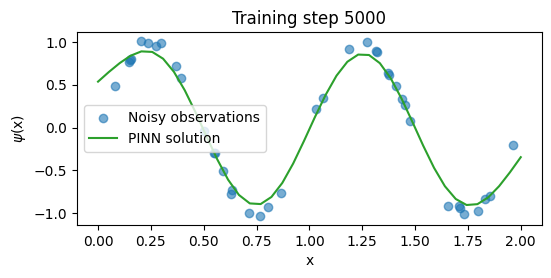

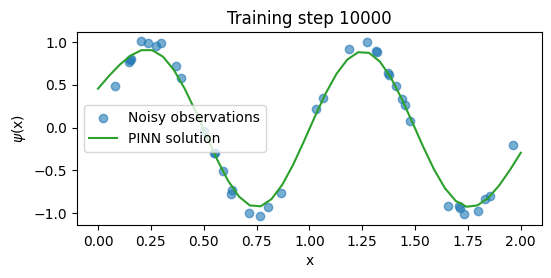

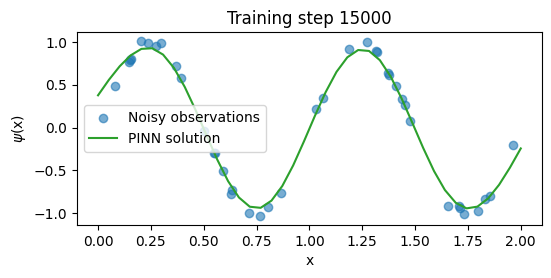

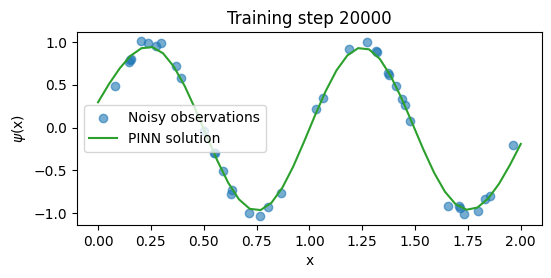

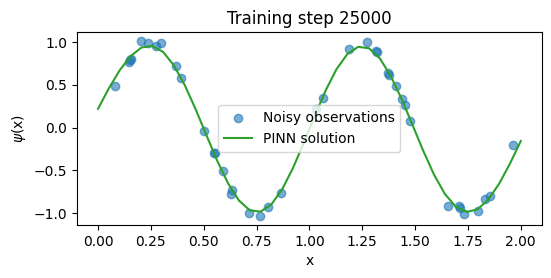

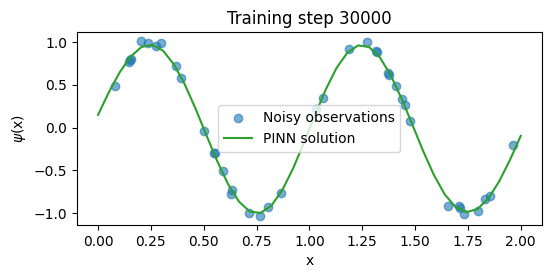

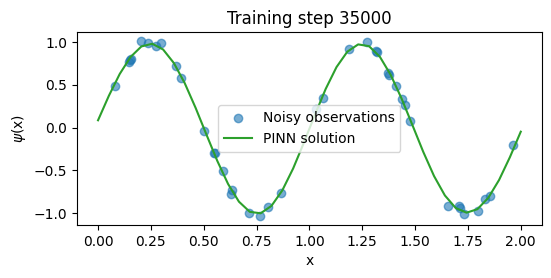

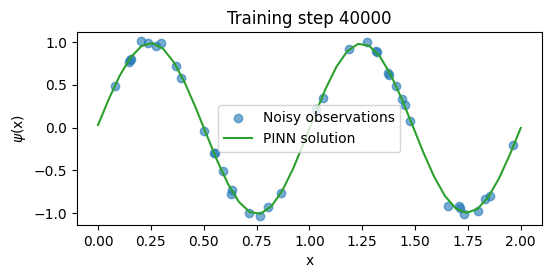

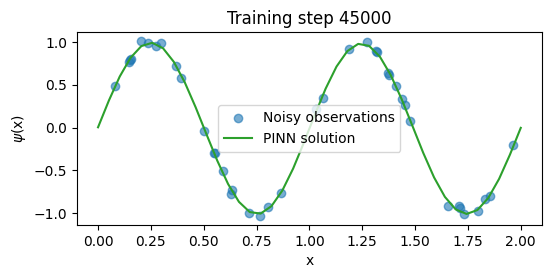

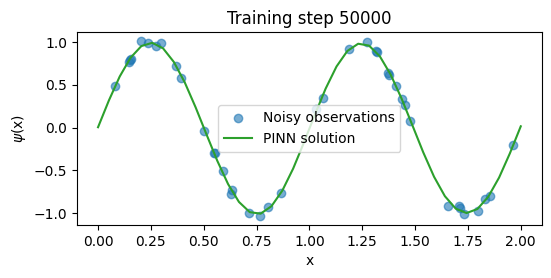

In [10]:
torch.manual_seed(123)

# define a neural network to train
model = FCN(1,1,32,3, ACTIVATION='gelu')

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,L.item(),30).view(-1,1).requires_grad_(True)

# treat k_squared as a learnable parameter
k_squared = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
k_squareds = []

# add k_squared to the optimiser
optimiser = torch.optim.Adam(list(model.parameters())+[k_squared],lr=1e-3)

# using the following hyperparameters:
lambda1 = 1e-4


losses = []


for i in range(50001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    
    # compute physics loss
    u = model(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + k_squared*u)**2)
    
    # compute data loss
    u = model(x_obs)
    loss2 = torch.mean((u - y_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = lambda1*loss1 + loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    k_squareds.append(k_squared.item())

    losses.append(loss.detach().cpu())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = model(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(x_obs[:,0], y_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.xlabel("x")
        plt.ylabel(r"$\psi$(x)")
        plt.legend()
        plt.show()

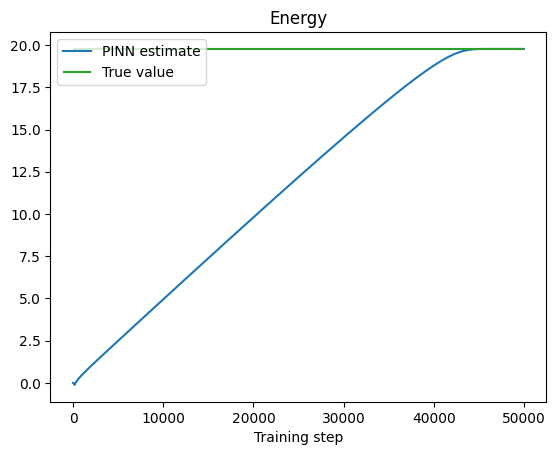

In [13]:
# Plot convergence of parameter: 

E_exp = ((np.array(k_squareds))*(hbar**2)) / (2 * m)

plt.figure()
plt.title("Energy")
plt.plot(E_exp, label="PINN estimate")
plt.hlines(E, 0, len(k_squareds), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

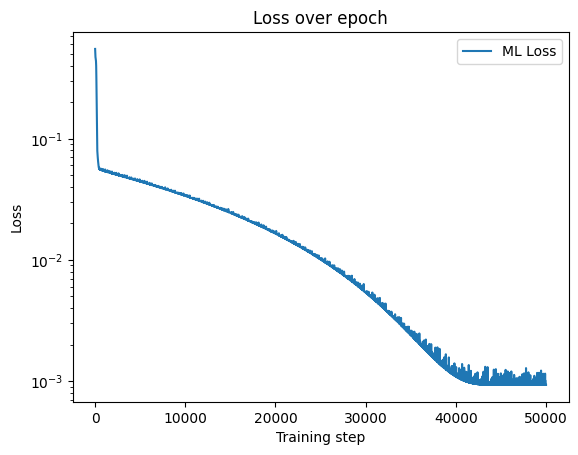

In [14]:
plot_losses(losses)

Converges really late...
However, loss function is not all that low!

lets take a differential equation as a* dx2+ b* dx+c*x=0
If we are inverting the problem for c, it seems that this parameter grows linearly until converging!

Let me try to do it without the physics loss function:

  0%|          | 0/20001 [00:00<?, ?it/s]

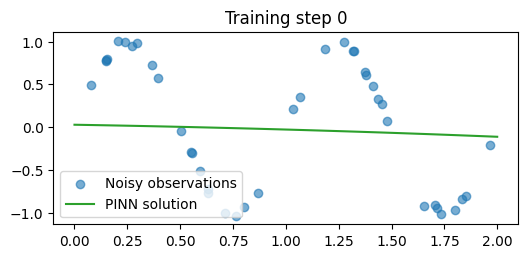

 25%|██▍       | 4986/20001 [00:31<02:34, 97.27it/s] 

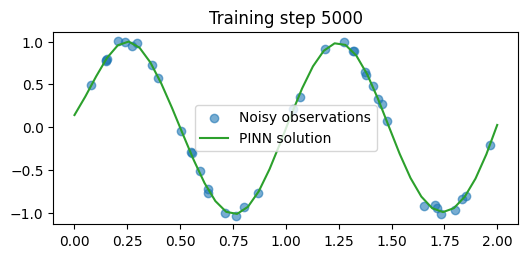

 50%|████▉     | 9997/20001 [01:01<00:58, 172.16it/s]

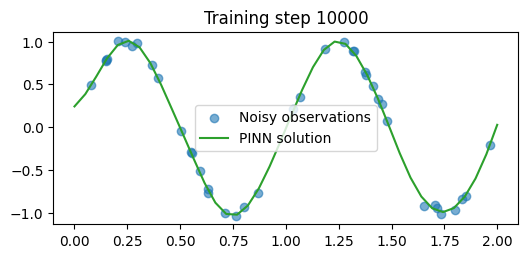

 75%|███████▍  | 15000/20001 [01:29<00:28, 178.17it/s]

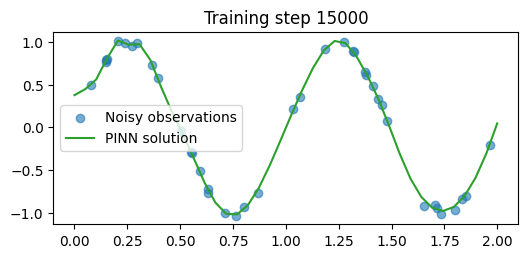

100%|█████████▉| 19994/20001 [01:58<00:00, 171.57it/s]

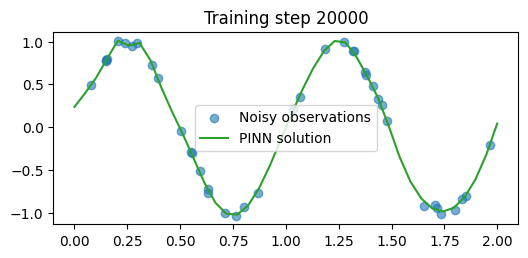

100%|██████████| 20001/20001 [01:59<00:00, 167.82it/s]


In [23]:
torch.manual_seed(123)

# define a neural network to train
model = FCN(1,1,32,3, ACTIVATION='gelu').to(device)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,L.item(),30).view(-1,1).requires_grad_(True).to(device)

# treat k_squared as a learnable parameter
k_squared = torch.nn.Parameter(torch.zeros(1, device = device, requires_grad=True))
k_squareds = []

# add k_squared to the optimiser
optimiser = torch.optim.Adam(list(model.parameters())+[k_squared],lr=1e-3)

# using the following hyperparameters:
lambda1 = 1e-4

# move data to device
x_obs = x_obs.to(device)
y_obs = y_obs.to(device)
x_test = x_test.to(device)

for i in tqdm(range(20001)):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    
    # compute physics loss
    u = model(t_physics).to(device)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + k_squared*u)**2)
    
    # compute data loss
    u = model(x_obs).to(device)
    loss2 = torch.mean((u - y_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    # loss = lambda1*loss1 + loss2
    loss = loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    k_squareds.append(k_squared.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = model(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(x_obs[:,0].cpu(), y_obs[:,0].cpu(), label="Noisy observations", alpha=0.6)
        plt.plot(x_test[:,0].cpu(), u[:,0].cpu(), label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

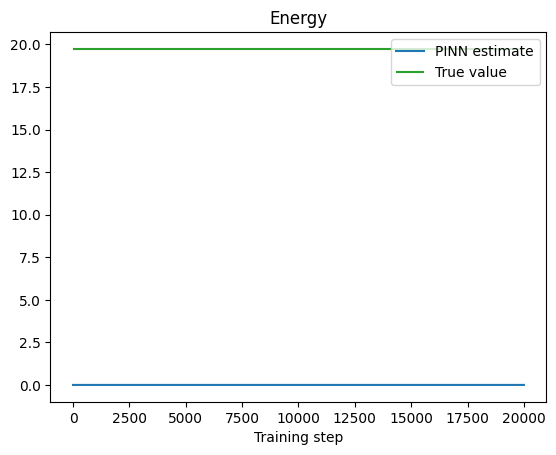

In [24]:
#Plot convergence of parameter: 

E_exp = ((np.array(k_squareds))*(hbar**2)) / (2 * m)

plt.figure()
plt.title("Energy")
plt.plot(E_exp, label="PINN estimate")
plt.hlines(E, 0, len(k_squareds), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

Without the physics loss term the results are clearly worse!